In [ ]:
import os, json,time, re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import scipy.io as sio
import pandas as pd
from operator import truediv
from sklearn.manifold import TSNE
from sklearn.decomposition import IncrementalPCA,  PCA
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical
from keras.layers import (Conv3D, Conv2D, Conv1D, MaxPooling1D, Dense, Dropout,
                          Flatten, Input, Reshape, MaxPooling2D, SeparableConv2D,
                          MaxPooling3D, MaxPooling2D, GlobalAveragePooling2D,
                          BatchNormalization, GlobalAveragePooling3D, concatenate, Reshape)

2024-11-25 14:36:07.887295: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 14:36:08.280560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 14:36:08.280600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 14:36:08.331700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 14:36:08.486215: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
## Loading Hyperspectral Datasets
def LoadHSIData(method):
    data_path = os.path.join(os.getcwd(),'../HSI/')
    if method == 'HH':
        HSI = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HongHu.mat'))['WHU_Hi_HongHu']
        GT = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HongHu_gt'))['WHU_Hi_HongHu_gt']
        Num_Classes = 22
        target_names = ['Red roof', 'Road', 'Bare soil', 'Cotton',
                        'Cotton firewood', 'Rape', 'Chinese cabbage',
                        'Pakchoi', 'Cabbage', 'Tuber mustard', 'Brassica parachinensis',
                        'Brassica chinensis', 'Small Brassica chinensis', 'Lactuca sativa',
                        'Celtuce', 'Film covered lettuce', 'Romaine lettuce',
                        'Carrot', 'White radish', 'Garlic sprout', 'Broad bean',
                        'Tree']
    elif method == 'HC':
        HSI = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan.mat'))['WHU_Hi_HanChuan']
        GT = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan_gt'))['WHU_Hi_HanChuan_gt']
        Num_Classes = 16
        target_names = ['Strawberry', 'Cowpea', 'Soybean', 'Sorghum',
                        'Water spinach', 'Watermelon', 'Greens', 'Trees', 'Grass',
                        'Red roof', 'Gray roof', 'Plastic', 'Bare soil', 'Road',
                        'Bright object', 'Water']
    elif method == 'Qingyun':
      HSI = sio.loadmat(os.path.join(data_path, 'QUH-Qingyun.mat'))['Chengqu']
      GT = sio.loadmat(os.path.join(data_path, 'QUH-Qingyun_GT.mat'))['ChengquGT']
      Num_Classes = 6
      target_names = ["Trees", "Concrete building", "Car", "Ironhide building",
                      "Plastic playground", "Asphalt road"]
    elif method == 'SA':
        HSI = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        GT = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
        Num_Classes = 16
        target_names = ['Weeds_1','Weeds_2','Fallow',
                        'Fallow_rough_plow','Fallow_smooth', 'Stubble','Celery',
                        'Grapes_untrained','Soil_vinyard_develop','Corn_Weeds',
                        'Lettuce_4wk','Lettuce_5wk','Lettuce_6wk',
                        'Lettuce_7wk', 'Vinyard_untrained','Vinyard_trellis']
    elif method == 'PU':
        HSI = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        GT = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
        Num_Classes = 9
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted','Soil','Bitumen',
                        'Bricks','Shadows']
    elif method == 'UH':
      HSI = sio.loadmat(os.path.join(data_path, 'HU.mat'))['HSI']
      GT = sio.loadmat(os.path.join(data_path, 'HU_gt.mat'))['gt']
      Num_Classes = 15
      target_names = ['Healthy grass', 'Stressed grass', 'Synthetic grass', 'Trees',
                    'Soil', 'Water', 'Residential', 'Commercial', 'Road',
                    'Highway', 'Railway', 'Parking Lot 1', 'Parking Lot 2',
                    'Tennis Court', 'Running Track']
    return HSI, GT, Num_Classes, target_names

In [ ]:
## Dimensional Reduction Method (If required)
def DLMethod(method, HSI, NC = 75):
    RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
    if method == 'PCA': ## PCA
        pca = PCA(n_components = NC, whiten = True)
        RHSI = pca.fit_transform(RHSI)
        RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    elif method == 'iPCA': ## Incremental PCA
        n_batches = 256
        inc_pca = IncrementalPCA(n_components = NC)
        for X_batch in np.array_split(RHSI, n_batches):
          inc_pca.partial_fit(X_batch)
        X_ipca = inc_pca.transform(RHSI)
        RHSI = np.reshape(X_ipca, (HSI.shape[0], HSI.shape[1], NC))
    return RHSI

In [4]:
def TrTeSplit(HSI, GT, trRatio, vrRatio, teRatio, randomState=345):
    # Split into train and test sets
    Tr, Te, TrC, TeC = train_test_split(HSI, GT, test_size=teRatio,
                                        random_state=randomState, stratify=GT)
    # Calculate the validation ratio based on the updated test and train ratios
    totalTrRatio = trRatio + vrRatio
    new_vrRatio = vrRatio / totalTrRatio
    # Split train set into train and validation sets
    Tr, Va, TrC, VaC = train_test_split(Tr, TrC, test_size=new_vrRatio,
                                        random_state=randomState, stratify=TrC)

    return Tr, Va, Te, TrC, VaC, TeC

In [ ]:
HSID = "UH" ## "LK", "HC", "HH", Qingyun, Pingan, Tangdaowan
DLM = "PCA" ## "PCA", "iPCA"
WS = 8
teRatio = 0.50
vrRatio = 0.90
trRatio = 0.10
k = 15
adam = tf.keras.optimizers.legacy.Adam(lr = 0.001, decay = 1e-06)
epochs = 20
batch_size = 56

/home/ahmad/miniconda3/envs/hsi/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
## Creat Patches for 3D (Spatial-Spectral) Models
def ImageCubes(HSI, GT, WS=WS, removeZeroLabels=True):
    num_rows, num_cols, num_bands = HSI.shape
    margin = int(WS / 2)
    padded_data = np.pad(HSI, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    image_cubes = np.zeros((num_rows * num_cols, WS, WS, num_bands))
    patchesLabels = np.zeros((num_rows * num_cols))
    patchIndex = 0
    for r in range(margin, num_rows + margin):
        for c in range(margin, num_cols + margin):
            cube = padded_data[r - margin: r + margin, c - margin: c + margin, :]
            image_cubes[patchIndex, :, :, :] = cube
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
      image_cubes = image_cubes[patchesLabels>0,:,:,:]
      patchesLabels = patchesLabels[patchesLabels>0]
      patchesLabels -= 1
    return image_cubes, patchesLabels

In [19]:
## Assigning Class Labels for Final Classification and Confusion Matrices
def ClassificationReports(TeC, Te_Pred, target_names):
    classification = classification_report(np.argmax(TeC, axis=1), np.argmax(Te_Pred, axis=1), target_names = target_names)
    oa = accuracy_score(np.argmax(TeC, axis=1), np.argmax(Te_Pred, axis=1))
    confusion = confusion_matrix(np.argmax(TeC, axis=1), np.argmax(Te_Pred, axis=1))
    list_diag = np.diag(confusion)
    list_raw_sum = np.sum(confusion, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    aa = np.mean(each_acc)
    kappa = cohen_kappa_score(np.argmax(TeC, axis=1), np.argmax(Te_Pred, axis=1))
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100

## Writing Results in CSV files
def CSVResults(file_name, classification, Confusion, Parameters, 
                          Flops, Tr_time, Te_Time, Kappa, OA, AA, Per_Class):
    classification = str(classification)
    confusion = str(Confusion)
    with open(file_name, 'w') as CSV_file:
      CSV_file.write('{} Tr_Time'.format(Tr_time))
      CSV_file.write('\n')
      CSV_file.write('{} Te_Time'.format(Te_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Flops'.format(Flops))
      CSV_file.write('\n')
      CSV_file.write('{} Parameters'.format(Parameters))
      CSV_file.write('\n')
      CSV_file.write('{} Kappa accuracy (%)'.format(Kappa))
      CSV_file.write('\n')
      CSV_file.write('{} Overall accuracy (%)'.format(OA))
      CSV_file.write('\n')
      CSV_file.write('{} Average accuracy (%)'.format(AA))
      CSV_file.write('\n')
      CSV_file.write('{}'.format(Per_Class))
      CSV_file.write('\n')
      CSV_file.write('{}'.format(classification))
      CSV_file.write('\n')
      CSV_file.write('{}'.format(Confusion))
    return CSV_file

## Plot Ground Truths
def GT_Plot(CRDHSI, GT, model, WS, k):
  Predicted = model.predict(CRDHSI)
  Predicted = np.argmax(Predicted, axis=1)
  height, width = np.shape(GT)
  ## Calculate the predicted Ground Truths
  outputs = np.zeros((height, width))
  count = 0
  for AA in range(height):
    for BB in range(width):
      target = int(GT[AA,BB])
      if target == 0:
        continue
      else:
        outputs[AA][BB] = Predicted[count]
        count = count+1
  return outputs

In [ ]:
## Main Function to load Datasets, Dimensional Reduction and Creating Patchs
HSI, GT, Num_Classes, target_names = LoadHSIData(HSID)
start = time.time()
RDHSI = DLMethod(DLM, HSI, NC = k)
end = time.time()
DL_Time = end - start
CRDHSI, CGT = ImageCubes(RDHSI, GT, WS = WS)
Tr, Va, Te, TrC, VaC, TeC = TrTeSplit(CRDHSI, CGT, trRatio, vrRatio, teRatio)
TrC = to_categorical(TrC)
VaC = to_categorical(VaC)
TeC = to_categorical(TeC)
CHSI = to_categorical(CGT)

In [ ]:
# Compute the Flops
def get_flops(model):
    total_flops = 0
    for layer in model.layers:
        flops = 0
        if isinstance(layer, tf.keras.layers.Conv2D):
            kernel_size = layer.kernel_size[0] * layer.kernel_size[1] * layer.input_shape[-1]
            flops = kernel_size * layer.output_shape[1] * layer.output_shape[2] * layer.filters
        elif isinstance(layer, tf.keras.layers.Dense):
            flops = layer.input_shape[-1] * layer.units
        elif isinstance(layer, tf.keras.layers.Flatten):
            continue
        total_flops += flops
    return total_flops

def compute_flops(model):
    flops = get_flops(model)
    return flops

In [ ]:
# Count samples per class
def count_class_samples(labels, num_classes):
    class_counts = {f"class_{i}": 0 for i in range(num_classes)}
    for label in labels:
        class_index = np.argmax(label)
        class_counts[f"class_{class_index}"] += 1
    return class_counts

In [ ]:
# Positional Encodding 
def get_positional_encoding_ssvit(max_len, d_emb):
    pos = np.arange(max_len)[:, np.newaxis]
    i = np.arange(d_emb)[np.newaxis, :]
    angles = pos / np.power(10000, 2 * i / d_emb)
    positional_encoding = np.zeros((max_len, d_emb))
    positional_encoding[:, ::2] = np.sin(angles[:, ::2])
    positional_encoding[:, 1::2] = np.cos(angles[:, 1::2])
    return positional_encoding[np.newaxis, ...]

In [ ]:
## Class tokens
class ClassTokenLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, **kwargs):
        super(ClassTokenLayer, self).__init__(**kwargs)
        self.embedding_dim = embedding_dim

    def build(self, input_shape):
        self.cls_token = self.add_weight(
            name="cls_token",
            shape=(1, 1, 1, self.embedding_dim),
            initializer=tf.zeros_initializer(),
            trainable=False)
    
    def call(self, inputs):
        cls_token_broadcasted = tf.broadcast_to(self.cls_token, [tf.shape(inputs)[0], 1, 1, 1, self.embedding_dim])
        return tf.concat([cls_token_broadcasted, inputs], axis=1)

In [ ]:
# Spatial-Spectral Transformer
class SST(tf.keras.layers.Layer):
    def __init__(self,num_heads, transformer_layer_depth, d_model, dff, dropout_rate=0.1, layernorm_eps=1e-6, **kwargs):
        super(SST, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.transformer_layer_depth = transformer_layer_depth
        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate
        self.layernorm_eps = layernorm_eps
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.dense1 = tf.keras.layers.Dense(dff, activation="relu")
        self.dense2 = tf.keras.layers.Dense(d_model)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

    def call(self, inputs, training):
        x = inputs
        for i in range(self.transformer_layer_depth):
            attn_output = self.mha(x, x)
            attn_output = self.dropout1(attn_output, training=training)
            attn_output = self.layernorm1(x + attn_output)
            ffn_output = self.dense1(attn_output)
            ffn_output = self.dense2(ffn_output)
            ffn_output = self.dropout2(ffn_output, training=training)
            ffn_output = self.layernorm2(attn_output + ffn_output)
            x = ffn_output
        return x

In [ ]:
# SST Function
def SSViT(WS, k, Num_Classes, num_transformer_layers=4, num_heads=8, dff=4 * 64, dropout_rate=0.1, layernorm_eps=1e-3):
    input_shape = (WS, WS, k)
    max_patch_size = min(input_shape[:3])
    patch_size = max_patch_size
    num_patches = ((input_shape[0] // patch_size) * (input_shape[1] // patch_size) * (input_shape[2] // patch_size))
    embedding_dim = 64
    inputs = Input(shape=input_shape, name="inputs")
    x = tf.expand_dims(inputs, axis=1)
    patch_embed = Conv3D(embedding_dim, kernel_size=(1, patch_size, patch_size),
        strides=(1, patch_size, patch_size), padding="valid", name="patch_embed")(x)
    cls_token_layer = ClassTokenLayer(embedding_dim=embedding_dim)
    patch_embed = cls_token_layer(patch_embed)
    pos_encoding = get_positional_encoding_ssvit(num_patches + 1, embedding_dim)
    patch_embed = patch_embed + pos_encoding
    for i in range(num_transformer_layers):
        if i == 0:
            transformer_layer = SST(num_heads=num_heads, transformer_layer_depth=1,
                d_model=embedding_dim, dff=dff, name=f"transformer_layer_{i}",)(patch_embed)
        else:
            transformer_layer = SST(num_heads=num_heads, transformer_layer_depth=1,
                d_model=embedding_dim, dff=dff, name=f"transformer_layer_{i}",)(transformer_layer)

    q = Dense(embedding_dim)(transformer_layer[:, 0, 0, 0])
    k = Dense(embedding_dim)(patch_embed[:, 1:, :, :, :])
    v = patch_embed[:, 1:, :, :, :]
    cross_attn_output = tf.matmul(q[:, tf.newaxis, :], k, transpose_b=True)
    cross_attn_output = cross_attn_output / tf.math.sqrt(
        tf.cast(embedding_dim, dtype=tf.float32)
    )
    cross_attn_output = tf.nn.softmax(cross_attn_output, axis=-1)
    cross_attn_output = tf.matmul(cross_attn_output, v)
    output_layer = tf.concat(
        [transformer_layer[:, 0, 0, 0], cross_attn_output[:, 0, 0, 0]], axis=-1
    )
    output_layer = Dense(dff, activation="relu")(output_layer)
    output_layer = Dense(dff, activation="relu")(output_layer)
    output_layer = Dense(Num_Classes, activation="softmax", name="output_layer")(output_layer)
    model = Model(inputs=inputs, outputs=output_layer, name="SSViT")
    return model

In [ ]:
# Uncertainty Sampling
def uncertainty_sampling(model, X_pool, query_size):
    probs = model.predict(X_pool)
    uncertainty = -np.max(probs, axis=1)  # Lower max prob indicates higher uncertainty
    query_indices = np.argsort(uncertainty)[-query_size:]  # Get indices of most uncertain samples
    return query_indices

In [ ]:
# Diversity Sampling 
def diversity_sampling(X_pool, query_size):
    num_samples, H, W, C = X_pool.shape
    query_indices = []
    neighborhood_size=3
    half_size = neighborhood_size // 2
    for i in range(num_samples):
        current_sample = X_pool[i]
        diversity_values = np.zeros((H, W))
        for h in range(half_size, H - half_size):
            for w in range(half_size, W - half_size):
                neighborhood = current_sample[h - half_size:h + half_size + 1, w - half_size:w + half_size + 1, :]
                reshaped_neighborhood = neighborhood.reshape(-1, C)
                distances = cdist(reshaped_neighborhood, reshaped_neighborhood, metric='euclidean')
                diversity_metric = np.mean(distances)
                diversity_values[h, w] = diversity_metric
        flat_diversity_values = diversity_values.flatten()
        query_indices = np.argsort(flat_diversity_values)[-query_size:]
    return query_indices

In [ ]:
# Hybrid Query
def hybrid_query_strategy(model, X_pool, query_size):
    uncertainty_indices = uncertainty_sampling(model, X_pool, query_size)
    diversity_indices = diversity_sampling(X_pool, query_size)
    query_indices = np.unique(np.concatenate((uncertainty_indices, diversity_indices)))
    return query_indices[:query_size]

Epoch 1/20


2024-11-24 20:05:45.189130: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-11-24 20:05:45.446711: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


2/2 [==============================] - 7s 2s/step - loss: 2.7262 - accuracy: 0.1333 - val_loss: 2.2167 - val_accuracy: 0.3238
Epoch 2/20
2/2 [==============================] - 2s 2s/step - loss: 2.0461 - accuracy: 0.3867 - val_loss: 1.8663 - val_accuracy: 0.4545
Epoch 3/20
2/2 [==============================] - 2s 2s/step - loss: 1.5953 - accuracy: 0.5733 - val_loss: 1.5643 - val_accuracy: 0.5798
Epoch 4/20
2/2 [==============================] - 2s 2s/step - loss: 1.1662 - accuracy: 0.8000 - val_loss: 1.3242 - val_accuracy: 0.6232
Epoch 5/20
2/2 [==============================] - 2s 2s/step - loss: 0.8516 - accuracy: 0.8667 - val_loss: 1.1645 - val_accuracy: 0.6621
Epoch 6/20
2/2 [==============================] - 2s 2s/step - loss: 0.5816 - accuracy: 0.8933 - val_loss: 1.0625 - val_accuracy: 0.6762
Epoch 7/20
2/2 [==============================] - 2s 2s/step - loss: 0.3951 - accuracy: 0.9467 - val_loss: 1.0778 - val_accuracy: 0.6688
Epoch 8/20
2/2 [==============================] - 2s

INFO:tensorflow:Assets written to: UH_trained_ssvit_model.tf/assets


Model saved at iteration 5 as 'final_model_iteration.tf'


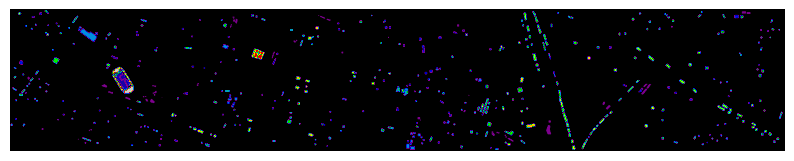

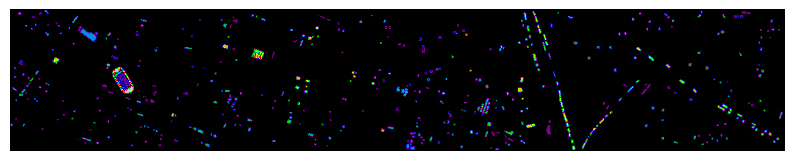

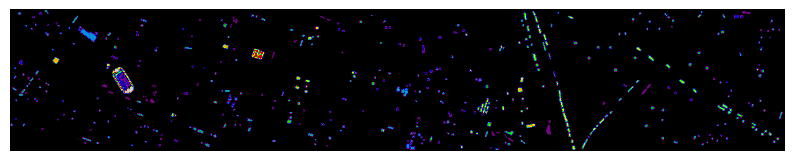

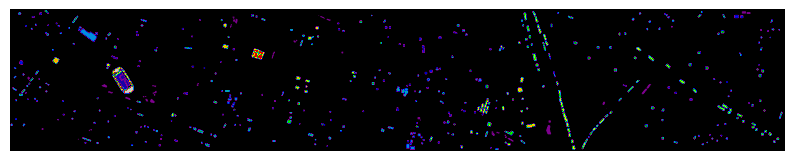

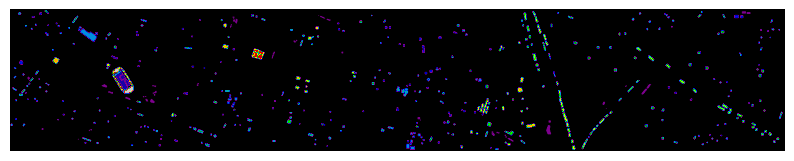

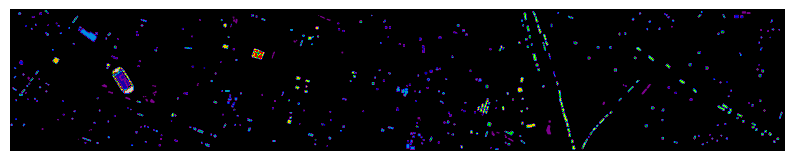

In [ ]:
# ATL-SST
def main_pipeline(WS, k, Num_Classes, CRDHSI, GT, Tr, TrC, Va, VaC, Te, TeC, num_iterations, query_percentage, epochs, batch_size):
    model = SSViT(WS, k, Num_Classes)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    # Initialize a dictionary to store sample counts
    sample_counts = {
        "initial_training_samples": Tr.shape[0],
        "initial_Train_class_counts": count_class_samples(TrC, Num_Classes),
        "initial_validation_samples": Va.shape[0],
        "initial_Val_class_counts": count_class_samples(VaC, Num_Classes),
        "Test_samples": Te.shape[0],
        "class_Test_counts": count_class_samples(TeC, Num_Classes),
        "iterations": []
    }
    # Initial training
    start_time = time.time()
    model.fit(x=Tr, y=TrC, batch_size=batch_size, epochs=epochs, validation_data=(Va, VaC))
    training_time = time.time() - start_time
    # Compute FLOPs for the initial model
    initial_flops = compute_flops(model)
    # Record initial counts
    sample_counts["iterations"].append({
        "iteration": 1,
        "training_samples": Tr.shape[0],
        "class_train_counts": count_class_samples(TrC, Num_Classes),
        "validation_samples": Va.shape[0],
        "class_Val_counts": count_class_samples(VaC, Num_Classes), 
        "Test_samples": Te.shape[0],
        "class_Test_counts": count_class_samples(TeC, Num_Classes)
    })
    
    ## Test Phase 
    start = time.time()
    Te_Pre = model.predict(Te)
    end = time.time()
    Te_Time = end - start
    trainable_parameters = model.count_params()
    classification, Confusion, OA, Per_Class, AA, Kappa = ClassificationReports(TeC, Te_Pre, target_names)
    file_name = f"1_{HSID}_{trRatio}_{WS}_Classification_Report.csv"
    CSV_file = CSVResults(file_name, classification, Confusion, trainable_parameters, 
                          initial_flops, training_time, Te_Time, Kappa, OA, AA, Per_Class)

    # Ground Truths for inital Training
    outputs = GT_Plot(CRDHSI, GT, model, WS, k)
    plt.figure(figsize=(10, 10))
    plt.imshow(outputs, cmap='nipy_spectral')
    plt.axis('off')
    file_name = f"1_{HSID}_{trRatio}_{WS}_Ground_Truths.png"
    plt.savefig(file_name, dpi=500, format='png', bbox_inches='tight', pad_inches=0)
    
    # Active Learning Iterations
    for i in range(1, num_iterations+1):
        print(f"Active Learning Iteration {i}/{num_iterations}")
        # Query new samples from the pool using uncertainty sampling
        query_size = int(query_percentage * Va.shape[0])
        query_indices = hybrid_query_strategy(model, Va, query_size)
        queried_X = Va[query_indices]
        queried_y = VaC[query_indices]
        
        # Add queried samples back to the training set
        Tr = np.concatenate([Tr, queried_X], axis=0)
        TrC = np.concatenate([TrC, queried_y], axis=0)
        # Remove queried samples from the pool
        Va = np.delete(Va, query_indices, axis=0)
        VaC = np.delete(VaC, query_indices, axis=0)
        # Record counts after querying
        sample_counts["iterations"].append({
            "iteration": i+1,
            "training_samples": Tr.shape[0],
            "class_train_counts": count_class_samples(TrC, Num_Classes),
            "validation_samples": Va.shape[0],
            "class_Val_counts": count_class_samples(VaC, Num_Classes)
        })
        # freeze feature learning layers and fine-tune classification layers
        for layer in model.layers[:-3]:
            layer.trainable = False
        # Fine-tuning the model
        fine_tune_start_time = time.time()
        history = model.fit(x=Tr, y=TrC, batch_size=batch_size, epochs=epochs, validation_data=(Va, VaC))
        fine_tune_time = time.time() - fine_tune_start_time
        # Compute FLOPs for the Fine_tuned model
        Fine_tuned_flops = compute_flops(model)
        Finetuned_parameters = model.count_params()
        ## Test Phase 
        start = time.time()
        Te_Pre = model.predict(Te)
        end = time.time()
        Te_Time = end - start
        ## Classification Report for Test Model
        classification, Confusion, OA, Per_Class, AA, Kappa = ClassificationReports(TeC, Te_Pre, target_names)
        file_name = f"{i+1}_{HSID}_{trRatio}_{WS}_Classification_Report.csv"
        CSV_file = CSVResults(file_name, classification, Confusion, Finetuned_parameters, 
                          Fine_tuned_flops, fine_tune_time, Te_Time, Kappa, OA, AA, Per_Class)
        # Ground Truths
        outputs = GT_Plot(CRDHSI, GT, model, WS, k)
        plt.figure(figsize=(10, 10))
        plt.imshow(outputs, cmap='nipy_spectral')
        plt.axis('off')
        file_name = f"{i+1}_{HSID}_{trRatio}_{WS}_Ground_Truths.png"
        plt.savefig(file_name, dpi=500, format='png', bbox_inches='tight', pad_inches=0)
        # Save the model during the last iteration
        if i == num_iterations:
            model.save(f"{HSID}_trained_ssvit_model.tf")
            print(f"Model saved at iteration {i} as 'final_model_iteration.tf'")

    # Save sample counts to a file
    sample_counts_filename = f"{HSID}_{trRatio}_{WS}_sample_counts.json"
    with open(sample_counts_filename, 'w') as f:
        json.dump(sample_counts, f, indent=4)    
    # Extract training and validation metrics
    accuracy = history.history['accuracy']
    loss = history.history['loss']
        # Check if validation metrics exist
    val_accuracy = history.history.get('val_accuracy', [])
    val_loss = history.history.get('val_loss', [])
    # Create a DataFrame
    history_df = pd.DataFrame({
        'Epoch': range(1, len(accuracy) + 1),
        'Training Accuracy': accuracy,
        'Training Loss': loss,
        'Validation Accuracy': val_accuracy if val_accuracy else ['N/A'] * len(accuracy),
        'Validation Loss': val_loss if val_loss else ['N/A'] * len(accuracy)
    })
    # Save to CSV
    history_df.to_csv(f"{HSID}_training_history.csv", index=False)
    return model
# Main
model = main_pipeline(WS, k, Num_Classes, CRDHSI, GT, Tr, TrC, Va, VaC, Te, TeC, num_iterations=5, 
                      query_percentage=0.02, epochs=epochs, batch_size=batch_size)

In [ ]:
## Across data classification
## Load the Model
from tensorflow.keras.models import load_model
trained_model = load_model(f"UH_trained_ssvit_model.tf") ## (UH--Change the model name which you trained).
print(f"Model loaded successfully from PU_trained_ssvit_model.tf")

## Load the Dataset to Test as cross data
HSID = "Qingyun" ## "LK", "HC", "HH", Qingyun, Pingan, Tangdaowan
HSI, GT, Num_Classes, target_names = LoadHSIData(HSID)
RDHSI = DLMethod(DLM, HSI, NC = k)
CRDHSI, CGT = ImageCubes(RDHSI, GT, WS = WS)
Tr, Va, Te, TrC, VaC, TeC = TrTeSplit(CRDHSI, CGT, 0.2, 0.8, 0.5)
TrC = to_categorical(TrC)
VaC = to_categorical(VaC)
TeC = to_categorical(TeC)

# Retrain the model (freeze feature learning layers and fine-tune classification layer)
x = trained_model.layers[-3].output 
output_layer = Dense(4 * 64, activation="relu")(x)
output_layer = Dense(64, activation="relu")(output_layer)
output_layer = Dense(Num_Classes, activation='softmax')(output_layer)
model = Model(inputs=trained_model.input, outputs=output_layer)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tuning the model
fine_tune_start_time = time.time()
history = model.fit(x=Tr, y=TrC, batch_size=batch_size, epochs=epochs, validation_data=(Va, VaC))
fine_tune_time = time.time() - fine_tune_start_time
Fine_tuned_flops = compute_flops(model)
Finetuned_parameters = model.count_params()
## Test Phase 
start = time.time()
Te_Pre = model.predict(Te)
end = time.time()
Te_Time = end - start
## Classification Report for Test Model
classification, Confusion, OA, Per_Class, AA, Kappa = ClassificationReports(TeC, Te_Pre, target_names)
print(classification)
file_name = f"{HSID}_{trRatio}_{WS}_Classification_Report.csv"
CSV_file = CSVResults(file_name, classification, Confusion, Finetuned_parameters, 
                          Fine_tuned_flops, fine_tune_time, Te_Time, Kappa, OA, AA, Per_Class)
# Ground Truths
Predicted = model.predict(CRDHSI)
Predicted = np.argmax(Predicted, axis=1)
height, width = np.shape(GT)
outputs = np.zeros((height, width))
count = 0
for AA in range(height):
  for BB in range(width):
    target = int(GT[AA,BB])
    if target == 0:
      continue
    else:
      outputs[AA][BB] = Predicted[count]
      count = count+1

plt.figure(figsize=(10, 10))
plt.imshow(outputs, cmap='nipy_spectral')
plt.axis('off')
file_name = f"{HSID}_{trRatio}_{WS}_Ground_Truths.png"
plt.savefig(file_name, dpi=500, format='png', bbox_inches='tight', pad_inches=0)

2024-11-25 12:38:30.136099: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-25 12:38:30.405568: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-25 12:38:30.405625: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-25 12:38:30.411340: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-25 12:38:30.411396: I external/local_xla/xla/stream_executor

Model loaded successfully from PU_trained_ssvit_model.tf
Epoch 1/20


2024-11-25 12:39:05.258701: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1706/1706 [==============================] - 145s 83ms/step - loss: 0.2830 - accuracy: 0.9078 - val_loss: 0.2094 - val_accuracy: 0.9319
Epoch 2/20
1706/1706 [==============================] - 144s 84ms/step - loss: 0.1919 - accuracy: 0.9339 - val_loss: 0.1864 - val_accuracy: 0.9351
Epoch 3/20
1706/1706 [==============================] - 145s 85ms/step - loss: 0.1614 - accuracy: 0.9443 - val_loss: 0.1577 - val_accuracy: 0.9457
Epoch 4/20
1706/1706 [==============================] - 144s 85ms/step - loss: 0.1418 - accuracy: 0.9513 - val_loss: 0.1470 - val_accuracy: 0.9505
Epoch 5/20
1706/1706 [==============================] - 142s 83ms/step - loss: 0.1266 - accuracy: 0.9558 - val_loss: 0.1380 - val_accuracy: 0.9528
Epoch 6/20
1706/1706 [==============================] - 141s 83ms/step - loss: 0.1122 - accuracy: 0.9609 - val_loss: 0.1262 - val_accuracy: 0.9572
Epoch 7/20
1706/1706 [==============================] - 142s 83ms/step - loss: 0.1028 - accuracy: 0.9638 - val_loss: 0.1285 - val

: 

In [ ]:
# Extract training and validation metrics
accuracy = history.history['accuracy']
loss = history.history['loss']
# Check if validation metrics exist
val_accuracy = history.history.get('val_accuracy', [])
val_loss = history.history.get('val_loss', [])
# Create a DataFrame
history_df = pd.DataFrame({ 
    'Epoch': range(1, len(accuracy) + 1),
    'Training Accuracy': accuracy,
    'Training Loss': loss,
    'Validation Accuracy': val_accuracy if val_accuracy else ['N/A'] * len(accuracy),
    'Validation Loss': val_loss if val_loss else ['N/A'] * len(accuracy)
})
# Save to CSV
history_df.to_csv(f"{HSID}_training_history.csv", index=False)